# Basic Win Percentage Prediction Encoding

In [22]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
from models.predictors import HandWinPredictor

In [23]:
df = pd.read_csv("data/hole_card_data.csv")

In [24]:
class PokerDataset(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, index):
        row = self.data.iloc[index]
        attributes = [row['suited'], row['connectedness'], row['pair']]
        hand_idx = row['hand_idx']
        win_percentage = row['river_win_rate']
        return (
            torch.tensor(hand_idx, dtype=torch.long),
            torch.tensor(attributes, dtype=torch.float32), 
            torch.tensor(win_percentage, dtype=torch.float32)
            )

In [25]:
dataset = PokerDataset(df)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [26]:
embedding_dim = 8
model = HandWinPredictor(hand_embedding_dim=embedding_dim, hidden_dims=[64, 32, 16])
optimizer = torch.optim.Adam(params=model.parameters(), lr=.001)
loss_fn = nn.MSELoss()
epochs = 500

In [27]:
train_losses = []
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in dataloader:
        hole_card_idx, hole_card_attributes, targets = batch
        optimizer.zero_grad()
        outputs = model(hole_card_idx, hole_card_attributes)
        loss = loss_fn(outputs, targets.unsqueeze(1))
        loss.backward()
        optimizer.step()
            
        total_loss += loss.item()
    avg_loss = total_loss/len(dataloader)
    train_losses.append(avg_loss)
    if epoch % (epochs//10) == 0:
        torch.save(model.encoder.state_dict(), 
                   f'hand_embedding_weights/model1/embeddings_epoch{epoch}.pt')
        
    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {round(avg_loss, 5)}")
        
torch.save(model.encoder.state_dict(), 'hand_embedding_weights/model1/embeddings.pt')

Epoch 50/500, Loss: 0.0037
Epoch 100/500, Loss: 0.00232
Epoch 150/500, Loss: 0.00167
Epoch 200/500, Loss: 0.0023
Epoch 250/500, Loss: 0.00095
Epoch 300/500, Loss: 0.0018
Epoch 350/500, Loss: 0.00151
Epoch 400/500, Loss: 0.00141
Epoch 450/500, Loss: 0.00072
Epoch 500/500, Loss: 0.00107


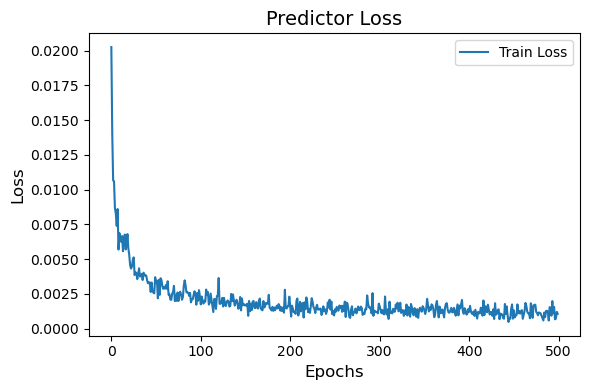

In [28]:
plt.figure(figsize=(6, 4))
sns.lineplot(x=list(range(epochs)), y=train_losses, label="Train Loss")
plt.title("Predictor Loss", fontsize=14)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend(fontsize=10) 
plt.tight_layout()
plt.show()